In [ ]:
!unzip /content/drive/MyDrive/combined_new.zip -d mendeley_leaf_data > /dev/null

In [ ]:
!pip install efficientnet_pytorch neptune-client > /dev/null

In [ ]:
!pip install albumentations -U > /dev/null

In [ ]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
import neptune
from efficientnet_pytorch import EfficientNet
import albumentations as A
from albumentations.pytorch import ToTensorV2
%matplotlib inline

In [ ]:
neptune.init(project_qualified_name='dalton/Cassa-Leaf')

Project(dalton/Cassa-Leaf)

In [ ]:
warnings.simplefilter('ignore')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(47)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/combined_new.csv')
train_df_kaggle = pd.read_csv('/content/drive/My Drive/cass_train.csv')

In [ ]:
class LeafDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_id'])
        x = cv2.imread(im_path)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

        if self.transforms:
            try:
                x = self.transforms(image=x)['image']
            except:
                x = self.transforms(x)
            
        if self.train:
            y = self.df.iloc[index]['label']
            return x, y
        else:
            return x
    
    def __len__(self):
        return len(self.df)
    
    
class Net(nn.Module):
    def __init__(self, arch, out_features):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=self.arch.fc.in_features, out_features=out_features, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=self.arch._fc.in_features, out_features=out_features, bias=True)
        
    def forward(self, inputs):
        return self.arch(inputs)

In [ ]:
train_transform = A.Compose([
    A.Resize(512, 512),
    A.RandomResizedCrop(512, 512),
    A.Transpose(p=0.5),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Cutout(p=1, num_holes=16, max_h_size=24, max_w_size=24),
    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [ ]:
PARAMS = {
    'architecture': 'efficientnet-b3',
    'learning_rate': 0.0002,
    'epochs': 25,
    'es_patience': 5,
    'folds': 4,
    'random_state': 47,
    'batch_size': 8,
    'reduce_lr_factor': 0.1,
    'label_smoothing': 0.1,
    'fold_number': 3
}

In [ ]:
if 'resnet' in PARAMS['architecture'] or 'resnext' in PARAMS['architecture']:
    arch = getattr(torchvision.models, PARAMS['architecture'])(pretrained=True)
elif 'efficientnet' in PARAMS['architecture']:
    arch = EfficientNet.from_pretrained(PARAMS['architecture'])
  
data_folder = '/content/mendeley_leaf_data'
train_losses = {i+1: [] for i in range(PARAMS['folds'])}
train_accs = {i+1: [] for i in range(PARAMS['folds'])}
val_accs = {i+1: [] for i in range(PARAMS['folds'])}

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


In [ ]:
neptune.create_experiment(name='leaf', params=PARAMS)

In [ ]:
oof = np.zeros((len(train_df_kaggle), 5))

skf = StratifiedKFold(n_splits=PARAMS['folds'], shuffle=True, random_state=PARAMS['random_state'])
for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['label']), 1):
    if fold != PARAMS['fold_number']:
        continue
    val_idx = val_idx[val_idx < len(train_df_kaggle)]  # validating only on original data
    print('=' * 20, 'Fold', fold, '=' * 20)
    model_path = f'{PARAMS["architecture"]}_fold_{fold}_denoise.pth'
    best_val = 0  # Best validation score within this fold
    patience = PARAMS['es_patience']  # Current patience counter

    if 'resnet' in PARAMS['architecture'] or 'resnext' in PARAMS['architecture']:
        arch = getattr(torchvision.models, PARAMS['architecture'])(pretrained=True)
    elif 'efficientnet' in PARAMS['architecture']:
        arch = EfficientNet.from_pretrained(PARAMS['architecture'])
    model = Net(arch=arch, out_features=5)

    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=PARAMS['learning_rate'])
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=PARAMS['reduce_lr_factor'])
    criterion = nn.CrossEntropyLoss()
    
    train = LeafDataset(df=train_df.iloc[train_idx].reset_index(drop=True),
                       imfolder=data_folder, 
                       train=True,
                       transforms=train_transform)
    val = LeafDataset(df=train_df.iloc[val_idx].reset_index(drop=True),
                       imfolder=data_folder, 
                       train=True,
                       transforms=test_transform)
    
    train_loader = DataLoader(dataset=train, batch_size=PARAMS['batch_size'], shuffle=True, num_workers=24)
    val_loader = DataLoader(dataset=val, batch_size=8, shuffle=False, num_workers=24)
    
    for epoch in range(PARAMS['epochs']):
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()
        
        for x, y in train_loader:
            x = torch.tensor(x, device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.long)
            optim.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optim.step()
            pred = torch.argmax(z, axis=1)
            correct += (pred.cpu() == y.cpu()).sum().item()
            epoch_loss += loss.item()
        train_acc = correct / len(train_idx)  # Train accuracy
        
        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.long, device=device)
        with torch.no_grad():  # Do not calculate gradient since we are only predicting
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val = torch.tensor(x_val, device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.long)
                z_val = model(x_val)
                val_pred = torch.argmax(z_val, axis=1)
                val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val.shape[0]] = val_pred.reshape(-1, 1)
            val_acc = accuracy_score(train_df.iloc[val_idx]['label'].values, val_preds.cpu())
            train_time = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
            train_losses[fold].append(epoch_loss)
            train_accs[fold].append(train_acc)
            val_accs[fold].append(val_acc)
            print(f'[{train_time}] | Epoch: {epoch+1:03} | Loss: {epoch_loss:.4f} | Train acc: {train_acc:.4f} | Val acc: {val_acc:.4f}')
            scheduler.step(val_acc)
            
            if val_acc >= best_val:
                best_val= val_acc
                patience = PARAMS['es_patience']
                torch.save(model, model_path)
            else:
                patience -= 1
                if patience == 0:
                    print(f'Early stopping. Best Val accuracy: {best_val:.4f}')
                    break

    model = torch.load(model_path)
    model.eval()
    val_preds = torch.zeros((len(val_idx), 5), dtype=torch.float32, device=device)
    with torch.no_grad():
        for j, (x_val, y_val) in enumerate(val_loader):
            x_val = torch.tensor(x_val, device=device, dtype=torch.float32)
            y_val = torch.tensor(y_val, device=device, dtype=torch.long)
            z_val = model(x_val)
            val_pred = torch.softmax(z_val, axis=1)
            val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val.shape[0]] += val_pred
        oof[val_idx] += val_preds.cpu().numpy()

==================== Fold 3 ====================
Loaded pretrained weights for efficientnet-b3
[0:14:43] | Epoch: 001 | Loss: 2275.8049 | Train acc: 0.8390 | Val acc: 0.8654
[0:14:42] | Epoch: 002 | Loss: 2017.7089 | Train acc: 0.8821 | Val acc: 0.8603
[0:14:39] | Epoch: 003 | Loss: 1939.5625 | Train acc: 0.8942 | Val acc: 0.8840
[0:14:36] | Epoch: 004 | Loss: 1884.1500 | Train acc: 0.9068 | Val acc: 0.8618
[0:14:26] | Epoch: 005 | Loss: 1820.1304 | Train acc: 0.9170 | Val acc: 0.8838
Epoch     5: reducing learning rate of group 0 to 2.0000e-05.
[0:14:22] | Epoch: 006 | Loss: 1673.2708 | Train acc: 0.9431 | Val acc: 0.8836
[0:14:12] | Epoch: 007 | Loss: 1629.0917 | Train acc: 0.9498 | Val acc: 0.8863
[0:14:23] | Epoch: 008 | Loss: 1595.9811 | Train acc: 0.9572 | Val acc: 0.8821
[0:14:35] | Epoch: 009 | Loss: 1566.3581 | Train acc: 0.9625 | Val acc: 0.8857
Epoch     9: reducing learning rate of group 0 to 2.0000e-06.
[0:14:36] | Epoch: 010 | Loss: 1547.5371 | Train acc: 0.9656 | Val acc

In [ ]:
pd.DataFrame(oof).to_csv(f'oof_{PARAMS["fold_number"]}.csv', index=False)

In [ ]:
neptune.log_metric('Train Acc', train_acc)
neptune.log_metric('Validation Acc', best_val)
neptune.log_artifact(model_path)
neptune.log_artifact(f'oof_{PARAMS["fold_number"]}.csv')

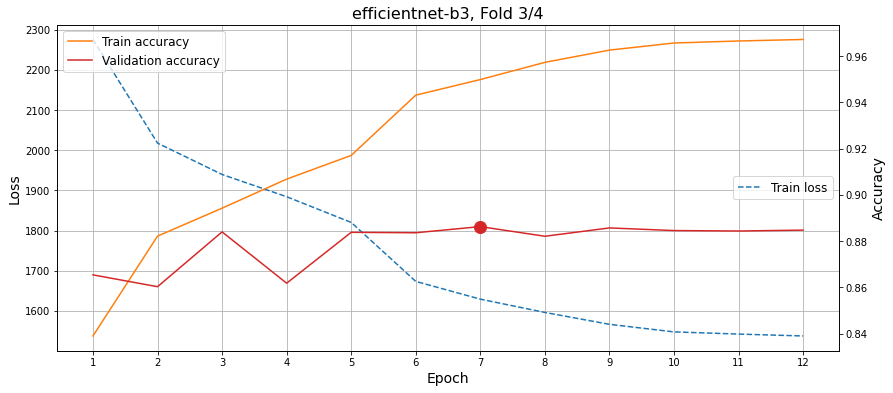

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
axes.plot(train_losses[PARAMS['fold_number']], '--', label='Train loss', color='tab:blue')
axes.grid();
axes.legend(fontsize=12, facecolor='white', loc=7);
axes.set_title(f'{PARAMS["architecture"]}, Fold {PARAMS["fold_number"]}/{PARAMS["folds"]}', fontsize=16);
axes.set_ylabel('Loss', fontsize=14);
axes.set_xlabel('Epoch', fontsize=14);
max_ticks = max(len(train_losses[PARAMS['fold_number']]), len(train_accs[PARAMS['fold_number']]), len(val_accs[PARAMS['fold_number']]))
axes.set_xticks(range(max_ticks));
axes.set_xticklabels(range(1, max_ticks+1));
axes2 = axes.twinx()
axes2.plot(np.array(val_accs[PARAMS['fold_number']]).argmax(), max(val_accs[PARAMS['fold_number']]), marker='o', markersize=12, color='tab:red')
axes2.plot(train_accs[PARAMS['fold_number']], label='Train accuracy', color='tab:orange')
axes2.plot(val_accs[PARAMS['fold_number']], label='Validation accuracy', color='tab:red')
axes2.legend(fontsize=12, facecolor='white');
axes2.set_ylabel('Accuracy', fontsize=14);
fig.savefig(f'{PARAMS["architecture"]}, Fold {PARAMS["fold_number"]}_loss_curv.png')
neptune.send_image('loss_curve', f'{PARAMS["architecture"]}, Fold {PARAMS["fold_number"]}_loss_curv.png')

In [ ]:
import re
import json
import requests
import ipykernel
from notebook.notebookapp import list_running_servers
from requests.compat import urljoin

def get_notebook_name():
    """
    Return the full path of the jupyter notebook.
    """
    kernel_id = re.search('kernel-(.*).json', ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'), params={'token': ss.get('token', '')})
        for nn in response.json():
            if nn['kernel']['id'] == kernel_id:
                notebook_name = nn['notebook']['name']
                return notebook_name

In [ ]:
neptune.log_artifact(f'/content/drive/My Drive/Colab Notebooks/{get_notebook_name()}')
neptune.stop()